In [46]:
nEpochs=20  # orig, longer training
#nEpochs=3  # quick testing during development

# Select one (and only one) model to train
USE_CGAN = False
USE_CVAE = True
USE_CVAECGAN = False

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
#if model_name not in {"cgan", "cvae", "cvaecgan"}:
#    raise Exception("Double check you are only using one model. The current model name is invalid")

%cd ./repos/Module_2_ArmandRathgeb/HPO/

[Errno 2] No such file or directory: './repos/Module_2_ArmandRathgeb/HPO/'
/project/nanocourse/SWE_OOP/train08/repos/Module_2_ArmandRathgeb/HPO


## 1. Import 3rd party libraries 

In [4]:
import os
import session_info
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[0], 
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    #)
except:
    Warning("Unable To configure Tensorflow GPU")
    
# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

#session_info.show()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 3. Show some our data

I0000 00:00:1748596124.507677   56913 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15494 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0
I0000 00:00:1748596124.508231   56913 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15506 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0
/project/nanocourse/SWE_OOP/train08/repos/Module_2_ArmandRathgeb/HPO/vaegan/data.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


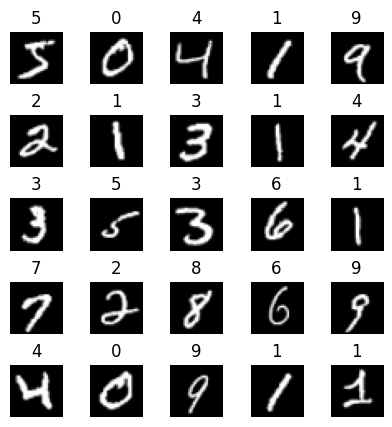

In [5]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist' + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

test_labels_onehot = tf.one_hot(data.labels_test,
                                depth=n_classes,
                                dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [47]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'generator_params' : {
        'generator_conv_layer_units' : [128,128],
        'generator_conv_layer_kernel_size' : [4,4],
        'generator_conv_layer_strides' : [(2,2), (2,2)],
        'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
        'discriminator_dense_layer_units' : [128],
        'generator_dense_layer_units' : [],
    },
    'discriminator_params' : {
        'discriminator_conv_layer_units' : [32,64],
        'discriminator_conv_layer_kernel_size' : [4,4],
        'discriminator_conv_layer_strides' : [(1,1), (2,2)],
        'discriminator_conv_layer_activation_functions' : ['relu','relu'],
        'discriminator_dense_layer_units' : [],
        'generator_dense_layer_units' : [],
    }
}

if USE_CGAN:
    model = ConditionalGAN(n_classes=n_classes,
                                 n_latent_dims = hpo_params['n_latent_dims'],
                                 generator_params = hpo_params['generator_params'],
                                 discriminator_params = hpo_params['discriminator_params'])
if USE_CVAE:
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
    )
if USE_CVAECGAN:
    hpo_params['n_latent_dims'] = 128
    model = ConditionalVAECGAN(adv_loss_weight=10., 
                            n_classes=n_classes,
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params=hpo_params['encoder_params'],
                            decoder_params=hpo_params['decoder_params'],
                            discriminator_params=hpo_params['discriminator_params']
    )


# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# All three models will use this input structure
#model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
#if USE_CVAE or USE_CVAECGAN:
#    model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
#if USE_CGAN or USE_CVAECGAN:
#    model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.vae_SOLUTIONS
Loaded version: vaegan.vae_SOLUTIONS


In [48]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,))
    gen_out  = model.generator.call(gen_in) 
    gen = tf.keras.Model(gen_in, gen_out) 
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(tf.TensorShape(model.image_shape,)) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims + model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(tf.TensorShape(model.image_shape,)) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()


=== OVERALL MODEL ====


Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== ENCODER SUBMODEL ====


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │      2,832 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │         64 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     16,448 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense0 (Dense)      │ (None, 128)       │  2,097,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_mean (Dense)  │ (None, 4)         │        516 │ dense0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_logvar        │ (None, 4)         │        516 │ dense0[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,117,912 (8.08 MB)

 Trainable params: 2,117,752 (8.08 MB)

 Non-trainable params: 160 (640.00 B)

=== DECODER SUBMODEL ====


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_to_conv (Dense)           │ (None, 16384)          │       245,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv0 (Conv2DTranspose)        │ (None, 32, 32, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (Activation)              │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,097 (1.25 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 160 (640.00 B)

In [49]:
_ = model([data.images_train[:1], labels_onehot[:1]])

## 6. Compile the model 

In [50]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)



## 7. Train (fit) the model on the data 

In [51]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - kl_loss: 54.4590 - recon_loss: 66.9009 - total_loss: 121.3600
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.9284 - recon_loss: 32.1795 - total_loss: 38.1079
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.6147 - recon_loss: 27.9133 - total_loss: 33.5280
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.6906 - recon_loss: 25.9942 - total_loss: 31.6848
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.7547 - recon_loss: 25.0191 - total_loss: 30.7738
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.7751 - recon_loss: 24.4475 - total_loss: 30.2226
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 5.8246 - recon_loss: 24.0076 - total_loss: 29.8322
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.8733 - recon_loss: 23.7126 - total_loss: 29.5858
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 5.8834 - reco

## 8. Training saves results to disk, now also plot training curves

/tmp/ipykernel_56913/2595891358.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


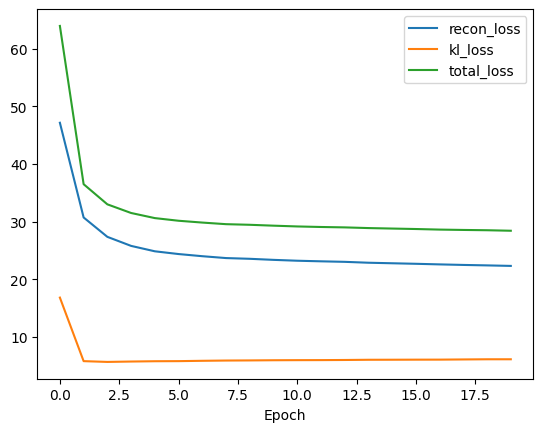

In [52]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['enc_loss', 'dec_loss', 'disc_loss', 'gen_loss', 'recon_loss', 'kl_loss', 'total_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
        
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
fig.show()

# Save the model 
model.save(os.path.join(output_dir, model_name+".keras"))


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


In [88]:
## !!!!IMPORTANT!!!!
## Keep the seed the same across ALL HPO experiments. Be sure to reinitialize for EVERY new model.
## !!!!IMPORTANT!!!!
# Instantiate a container with the hyperparameter(s) you want to test
# Instantiate a model for a hyperparameter (combination)
## Note: I would recommend naming your model with the specific HPO you are trying at the moment.

# Build a model with input / output dimensions

# Compile the model

# Fit model to the data

# Plot the training curves for the model

# Save the model 

# Assuming you are using the provided callbacks and save the model/outputs appropriately,
# You should be able to use the provided `image_viewer` to look at the fakes and/or recons just by
# Passing in a model's name/directory.

def save_plot(logs, losses, output_dir, training):
    fig,ax = plt.subplots()
    for l in losses:
        if type(logs) is tf.keras.callbacks.History:
            loss_v = logs.history[l]
        else:
            loss_v = logs
        x = np.arange(len(loss_v))
        ax.plot(x, loss_v, label=l)
    ax.legend()
    ax.set_xlabel('Epoch')
    fig.savefig(os.path.join(output_dir, training + '_curves.png'), transparent=False)
    plt.close(fig)
 

test_onehot = tf.one_hot(data.labels_test,
                        depth=n_classes,
                        dtype=tf.float32).numpy()

# Current loss value, index
min_loss = (np.inf, -1)

for lr in range(3, 5):
    learning_rate = 10**(-lr)
    hpo_params['learning_rate'] = learning_rate
    for ld in [32,64,128,256]:
        hpo_params['n_latent_dims'] = ld
        output_dir = './outputs/mnist_hpo_cvae_' + str(learning_rate) + '_' + str(ld)
        os.makedirs(output_dir, exist_ok=True)
        tf.random.set_seed(1234)

        model = ConditionalVAECGAN(
            adv_loss_weight=10,
            n_classes=n_classes,
            n_latent_dims=hpo_params['n_latent_dims'],
            encoder_params=hpo_params['encoder_params'],
            decoder_params=hpo_params['decoder_params'],
            discriminator_params=hpo_params['discriminator_params']
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate'])
        )
        callback = SaveImagesConditional(
            output_dir=output_dir,
            model=model,
            example_images=data.images_train[:10],
            example_labels=labels_onehot[:10],
            n_generated_images=10,
            n_latent_dims=model.n_latent_dims
        )
        logs=model.fit([data.images_train, labels_onehot],
            batch_size=128,
            epochs=20,
            callbacks=[callback]
        )
        save_plot(logs, ['enc_loss', 'dec_loss', 'disc_loss'], output_dir, "training")
       

        logs=model.evaluate([data.images_test, test_onehot],
            batch_size=128,
            callbacks=[callback]
        )
        #save_plot(logs, ['recon_loss'], output_dir, "testing")

        loss = logs
        if loss < min_loss[0]:
            min_loss = (loss, (lr,ld))

        print(
            f"Learning rate: {learning_rate} === "
            f"Latent dims: {ld} === "
            f"Reconstruction loss: {loss}"
        ) 
        model.save(os.path.join(output_dir, "cvae.keras"))
# Learning rate of 0.01 gave me nans

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0135 - dec_loss: 24.0617 - disc_loss: 0.0136 - enc_loss: 34.1825 - kl_loss: 10.1687 - recon_loss: 24.0138 - top_1_acc: 0.9976
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0108 - dec_loss: 22.6427 - disc_loss: 0.0108 - enc_loss: 32.8387 - kl_loss: 10.2396 - recon_loss: 22.5992 - top_1_acc: 0.9985
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0085 - dec_loss: 21.5628 - disc_loss: 0.0086 - enc_loss: 31.7779 - kl_loss: 10.2523 - recon_loss: 21.5256 - top_1_acc: 0.9992
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0068 - dec_loss: 20.6720 - disc_loss: 0.0069 - enc_loss: 30.9513 - kl_loss: 10.3123 - recon_loss: 20.6390 - top_1_acc: 0.9994
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - class_loss: 0.0052 - dec_loss: 20.0495 - disc_loss: 0.0053 - enc_loss: 30.3781 - kl_loss: 10.3591 - recon_loss: 20.0190 - top_1_acc: 0.9997
Epoch 13/20
469/469 ━━━━━━━━

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


70/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - recon_loss: 16.7952

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - recon_loss: 16.7593
Learning rate: 0.0001 === Latent dims: 128 === Reconstruction loss: 16.506277084350586
Epoch 1/20


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - class_loss: 0.5260 - dec_loss: 132.2891 - disc_loss: 0.5682 - enc_loss: 144.3626 - kl_loss: 13.1341 - recon_loss: 131.2285 - top_1_acc: 0.8322

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - class_loss: 0.5242 - dec_loss: 132.0228 - disc_loss: 0.5661 - enc_loss: 144.0743 - kl_loss: 13.1112 - recon_loss: 130.9631 - top_1_acc: 0.8328
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0748 - dec_loss: 54.4670 - disc_loss: 0.0754 - enc_loss: 62.2480 - kl_loss: 8.1468 - recon_loss: 54.1012 - top_1_acc: 0.9780
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - class_loss: 0.0485 - dec_loss: 42.1117 - disc_loss: 0.0488 - enc_loss: 50.4325 - kl_loss: 8.5106 - recon_loss: 41.9219 - top_1_acc: 0.9864
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0361 - dec_loss: 36.0872 - disc_loss: 0.0363 - enc_loss: 44.9306 - kl_loss: 8.9693 - recon_loss: 35.9613 - top_1_acc: 0.9901
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0279 - dec_loss: 32.5446 - disc_loss: 0.0280 - enc_loss: 41.7536 - kl_loss: 9.2979 - recon_loss: 32.4557 - top_1_acc: 0.9930
Epoch 6/20
469/469 ━━━━━━━━━━━━━

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


71/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - recon_loss: 18.3696

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - recon_loss: 18.3374
Learning rate: 0.0001 === Latent dims: 256 === Reconstruction loss: 18.088436126708984


In [93]:
loaddir = "./outputs/mnist_hpocvae_" + str(10**_-min_loss[1][0]) + "_" + str(min_loss[1][1])
model = tf.keras.models.load_model(os.path.join(loaddir, 'cvae.keras'))

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


ValueError: File not found: filepath=./outputs/mnist_hpocvae_tf.Tensor(
[[[[0.15600562]
   [0.15818381]
   [0.14704537]
   ...
   [0.15960717]
   [0.15726757]
   [0.1599958 ]]

  [[0.16354704]
   [0.15566301]
   [0.15884495]
   ...
   [0.15447879]
   [0.15814567]
   [0.153332  ]]

  [[0.15766048]
   [0.16275287]
   [0.1498816 ]
   ...
   [0.15155458]
   [0.1423881 ]
   [0.15662909]]

  ...

  [[0.1603558 ]
   [0.15133381]
   [0.16977835]
   ...
   [0.15624261]
   [0.15188336]
   [0.16242266]]

  [[0.15946174]
   [0.15668559]
   [0.13833356]
   ...
   [0.15258813]
   [0.15481138]
   [0.16267776]]

  [[0.16303825]
   [0.14745402]
   [0.15604305]
   ...
   [0.15594482]
   [0.15661478]
   [0.16439581]]]], shape=(1, 32, 32, 1), dtype=float32)_64/cvae.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Retrain since I don't feel like getting module loading working
print(min_loss)
hpo_params['learning_rate'] = 10**-min_loss[1][0]
hpo_params['n_latent_dims'] = min_loss[1][1]
model = ConditionalVAECGAN(
    adv_loss_weight=10,
    n_classes=n_classes,
    n_latent_dims=hpo_params['n_latent_dims'],
    encoder_params=hpo_params['encoder_params'],
    decoder_params=hpo_params['decoder_params'],
    discriminator_params=hpo_params['discriminator_params']
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate'])
)
callback = SaveImagesConditional(
    output_dir=output_dir,
    model=model,
    example_images=data.images_train[:10],
    example_labels=labels_onehot[:10],
    n_generated_images=10,
    n_latent_dims=model.n_latent_dims
)
logs=model.fit([data.images_train, labels_onehot],
    batch_size=128,
    epochs=20,
    callbacks=[callback]
)

(<tf.Tensor: shape=(), dtype=float32, numpy=14.704903602600098>, (3, 64))
Epoch 1/20


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - class_loss: 0.3705 - dec_loss: 55.4625 - disc_loss: 0.4045 - enc_loss: 147.3270 - kl_loss: 92.4267 - recon_loss: 54.9004 - top_1_acc: 0.9017

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - class_loss: 0.3691 - dec_loss: 55.3577 - disc_loss: 0.4030 - enc_loss: 146.8211 - kl_loss: 92.0236 - recon_loss: 54.7975 - top_1_acc: 0.9021
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0584 - dec_loss: 24.8908 - disc_loss: 0.0592 - enc_loss: 36.3609 - kl_loss: 11.5320 - recon_loss: 24.8289 - top_1_acc: 0.9815
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0361 - dec_loss: 20.7988 - disc_loss: 0.0371 - enc_loss: 32.1387 - kl_loss: 11.3675 - recon_loss: 20.7712 - top_1_acc: 0.9881
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0228 - dec_loss: 19.0501 - disc_loss: 0.0237 - enc_loss: 30.2515 - kl_loss: 11.2221 - recon_loss: 19.0294 - top_1_acc: 0.9927
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0189 - dec_loss: 18.1408 - disc_loss: 0.0198 - enc_loss: 29.1780 - kl_loss: 11.0595 - recon_loss: 18.1186 - top_1_acc: 0.9941
Epoch 6/20
469/469 ━━━━━━━━━━━

In [243]:
def trawl_image_latent_space(dataset, model, nvis=3, alpha=.1):
    test_images = dataset.images_test
    test_onehot = tf.one_hot(dataset.labels_test,
                            depth=n_classes,
                            dtype=tf.float32).numpy()
    recons = []
    for n in range(nvis):
        r1,r2 = tf.random.uniform((2,), 0, test_images.shape[0], tf.dtypes.int32).numpy()
        microbatch = model.make_conditional_input(test_images[[r1,r2],:], test_onehot[[r1,r2],:])
        z_mean, z_logvar = model.encoder(microbatch, training=False)

        samples = z_mean + tf.random.normal(shape=z_mean.shape)*tf.exp(.5*z_logvar)
        z1,z2 = samples
        # z1,z2 = z_mean

        alphas = np.arange(0, 1, alpha)
        interps = tf.cast(tf.stack([(1-a) * z1 + a * z2 for a in alphas]), tf.float32)
        labels = tf.cast(tf.concat([(1-a) * test_onehot[r1,:][None,:] + a * test_onehot[r2,:][None,:] for a in alphas], 0), tf.float32)
        cond_in = tf.concat([interps, labels], -1)
        recon = model.decoder(cond_in,training=False)
        recons.append(recon)
    return recons

def trawl_class_space(model, class_labels, samples):
    recons = []
    for label in class_labels:
        z = tf.random.normal((samples, model.n_latent_dims))
        y = tf.one_hot([label] * samples, depth=model.n_classes)
        recon = model.decoder(tf.concat([z, y], -1), training=False)
        recons.append(recon)
    return recons 


In [141]:
def show(images):
    n = int(np.sqrt(images.shape[0]))
    fig,axs = plt.subplots(n,n)
    axs = axs.flatten()
    for i,ax in enumerate(axs):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].axis('off')


In [221]:
space_recons = trawl_class_space(model, [1, 2, 3], 100)

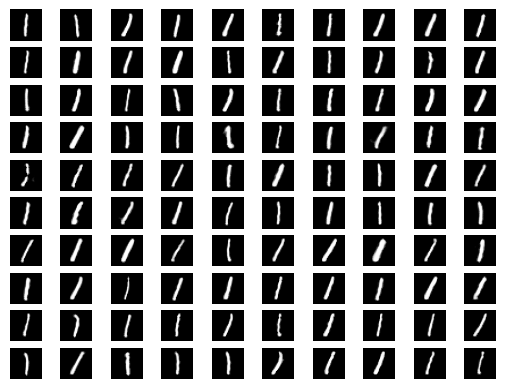

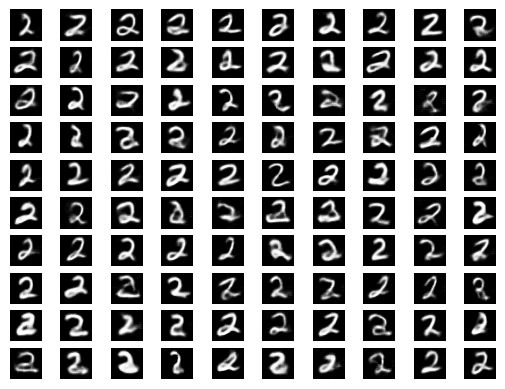

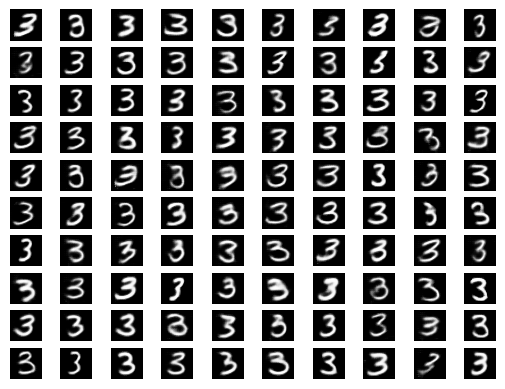

In [143]:
for s in space_recons:
    show(s)

In [236]:
irecons = trawl_image_latent_space(data, model, nvis=3, alpha=.01)

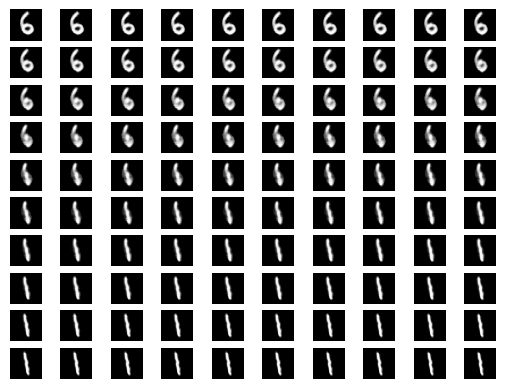

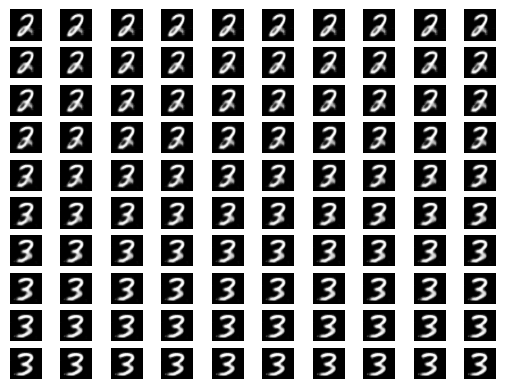

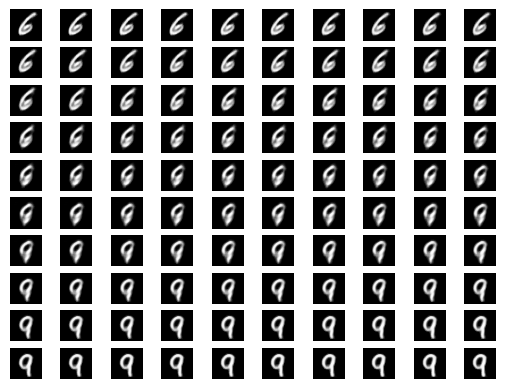

In [237]:
for i in irecons:
    show(i)